In [0]:
import numpy as np 
import pandas as pd 
from numpy import array
import matplotlib.pyplot as plt 

In [11]:
dataf = pd.read_csv('coronavirus.csv')
dataf

,Day,Confirmed,Deaths,Recovered
0,23,844,25,30
1,24,1312,41,26
2,25,2015,56,49
3,26,2801,80,54
4,27,4579,106,63
5,28,6061,132,63
6,29,7816,170,133
7,30,9821,213,187
8,31,11948,259,267
9,32,14551,304,416


In [5]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
def load_data(data, time_step=2, after_day=1, validate_percent=0.67):
    seq_length = time_step + after_day
    result = []
    for index in range(len(data) - seq_length + 1):
        result.append(data[index: index + seq_length])
    result = np.array(result)
    print('total data: ', result.shape)

    train_size = int(len(result) * validate_percent)
    train = result[:train_size, :]
    validate = result[train_size:, :]

    x_train = train[:, :time_step]
    y_train = train[:, time_step:]
    x_validate = validate[:, :time_step]
    y_validate = validate[:, time_step:]

    return [x_train, y_train, x_validate, y_validate]

In [0]:
def base_model(feature_len=3, after_day=3, input_shape=(8, 1)):
    model = Sequential()

    model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))

    model.add(RepeatVector(after_day))
    model.add(LSTM(200, return_sequences=True))

    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))

    return model

In [0]:
def seq2seq(feature_len=1, after_day=1, input_shape=(8, 1)):
    '''
    Encoder:
    X = Input sequence
    C = LSTM(X); The context vector

    Decoder:
    y(t) = LSTM(s(t-1), y(t-1)); where s is the hidden state of the LSTM(h and c)
    y(0) = LSTM(s0, C); C is the context vector from the encoder.
    '''

    # Encoder
    encoder_inputs = Input(shape=input_shape) 
    encoder = LSTM(units=100, return_state=True,  name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 100), name='reshapor')
    decoder = LSTM(units=100, return_sequences=True, return_state=True, name='decoder')

    # Densor
    densor_output = Dense(units=feature_len, activation='linear', name='output')

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []



    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [0]:
def normalize_data(data, scaler, feature_len):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)
    return normalize_data

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = normalize_data(dataf, scaler,dataf.shape[1])

In [13]:
x_train, y_train, x_validate, y_validate = load_data(data,time_step=3, after_day=4, validate_percent=0.5)
print('train data: ', x_train.shape, y_train.shape)
print('validate data: ', x_validate.shape, y_validate.shape)

total data:  (10, 7, 4)
train data:  (5, 3, 4) (5, 4, 4)
validate data:  (5, 3, 4) (5, 4, 4)


In [14]:
y_validate

array([[[0.53333333, 0.32629073, 0.33476395, 0.11761835],
        [0.6       , 0.40277982, 0.39914163, 0.19033675],
        [0.66666667, 0.4861156 , 0.48211731, 0.33479746],
        [0.73333333, 0.58129353, 0.57367668, 0.43289409]],

       [[0.6       , 0.40277982, 0.39914163, 0.19033675],
        [0.66666667, 0.4861156 , 0.48211731, 0.33479746],
        [0.73333333, 0.58129353, 0.57367668, 0.43289409],
        [0.8       , 0.69668831, 0.66809728, 0.602245  ]],

       [[0.66666667, 0.4861156 , 0.48211731, 0.33479746],
        [0.73333333, 0.58129353, 0.57367668, 0.43289409],
        [0.8       , 0.69668831, 0.66809728, 0.602245  ],
        [0.86666667, 0.80608857, 0.77253219, 0.76866764]],

       [[0.73333333, 0.58129353, 0.57367668, 0.43289409],
        [0.8       , 0.69668831, 0.66809728, 0.602245  ],
        [0.86666667, 0.80608857, 0.77253219, 0.76866764],
        [0.93333333, 0.89903323, 0.8769671 , 0.88726208]],

       [[0.8       , 0.69668831, 0.66809728, 0.602245  ],
      

In [0]:
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.callbacks import ModelCheckpoint

In [16]:
input_shape = (3, data.shape[1])
model = seq2seq(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc'])
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 4)         0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 100), (None, 42000       input_1[0][0]                    
__________________________________________________________________________________________________
reshapor (Reshape)              (None, 1, 100)       0           encoder[0][0]                    
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, 1, 100), (No 80400       reshapor[0][0]                   
                                                                 encoder[0][1]          

In [17]:
history = model.fit(x_train, y_train, batch_size=3, epochs=70)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/70





5/5 [==============================] - 3s 601ms/step - loss: 0.0911 - acc: 0.0000e+00
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.0809 - acc: 0.0000e+00
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.0720 - acc: 0.0500
Epoch 4/70
5/5 [==============================] - 0s 7ms/step - loss: 0.0620 - acc: 0.4500
Epoch 5/70
5/5 [==============================] - 0s 5ms/step - loss: 0.0520 - acc: 0.8500
Epoch 6/70
5/5 [==============================] - 0s 5ms/step - loss: 0.0428 - acc: 1.0000
Epoch 7/70
5/5 [==============================] - 0s 5ms/step - loss: 0.0319 - acc: 1.0000
Epoch 8/70
5/5 [==============================] - 0s 6ms/step - loss: 0.0205 - acc: 1.0000
Epoch 9/70
5/5 [==============================] - 0s 7ms/step - loss: 0.0130 - acc: 1.0000
Epoch 10/70
5/5 [==============================] - 0s 7ms/step - loss

In [18]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))

----------------------------------------------------------------------------------------------------
Train Score: 0.00038220 MSE (0.01954999 RMSE ) , 100.00000000  ACC
Validation Score: 0.01461392 MSE (0.12088806 RMSE ) , 100.00000000  ACC


In [0]:
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)

In [0]:
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

In [0]:
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)

In [22]:
y_validate

array([[[3.1000e+01, 1.1948e+04, 2.5900e+02, 2.6700e+02],
        [3.2000e+01, 1.4551e+04, 3.0400e+02, 4.1600e+02],
        [3.3000e+01, 1.7387e+04, 3.6200e+02, 7.1200e+02],
        [3.4000e+01, 2.0626e+04, 4.2600e+02, 9.1300e+02]],

       [[3.2000e+01, 1.4551e+04, 3.0400e+02, 4.1600e+02],
        [3.3000e+01, 1.7387e+04, 3.6200e+02, 7.1200e+02],
        [3.4000e+01, 2.0626e+04, 4.2600e+02, 9.1300e+02],
        [3.5000e+01, 2.4553e+04, 4.9200e+02, 1.2600e+03]],

       [[3.3000e+01, 1.7387e+04, 3.6200e+02, 7.1200e+02],
        [3.4000e+01, 2.0626e+04, 4.2600e+02, 9.1300e+02],
        [3.5000e+01, 2.4553e+04, 4.9200e+02, 1.2600e+03],
        [3.6000e+01, 2.8276e+04, 5.6500e+02, 1.6010e+03]],

       [[3.4000e+01, 2.0626e+04, 4.2600e+02, 9.1300e+02],
        [3.5000e+01, 2.4553e+04, 4.9200e+02, 1.2600e+03],
        [3.6000e+01, 2.8276e+04, 5.6500e+02, 1.6010e+03],
        [3.7000e+01, 3.1439e+04, 6.3800e+02, 1.8440e+03]],

       [[3.5000e+01, 2.4553e+04, 4.9200e+02, 1.2600e+03],
      

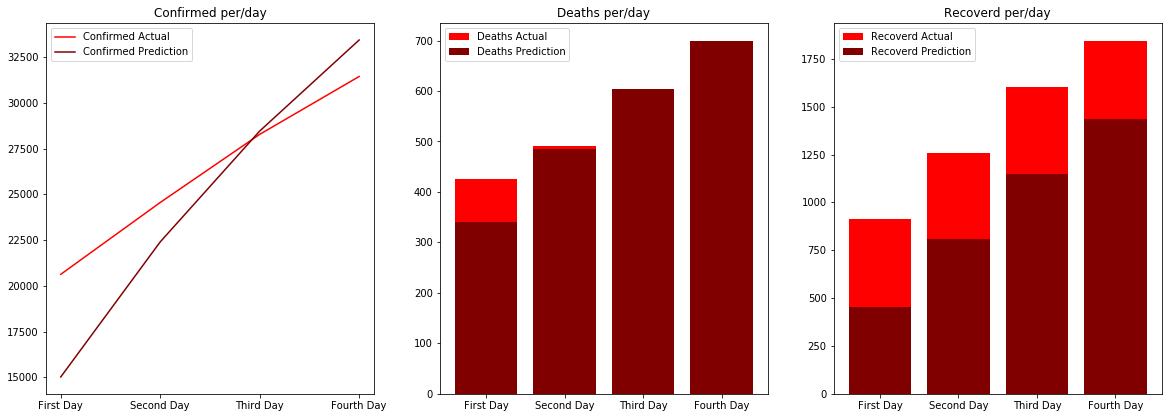

In [23]:
day = ['First Day','Second Day','Third Day','Fourth Day']

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,1][3],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,1][3],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,2][3],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,2][3],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,3][3],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,3][3],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()

plt.show()

In [24]:
x_train, y_train, x_validate, y_validate = load_data(data,time_step=3, after_day=4, validate_percent=0.)

total data:  (10, 7, 4)


In [0]:
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)

In [27]:
x_test = data[13:]
x_test = np.reshape(x_test, (1, x_test.shape[0], x_test.shape[1]))
x_test.shape

(1, 3, 4)

In [28]:
next_predict = model.predict(x_test)
next_predict_res = inverse_normalize_data(next_predict, scaler)
next_predict_res

array([[[3.9004208e+01, 2.5959381e+04, 6.2626648e+02, 1.1130024e+03],
        [4.3558620e+01, 3.9634078e+04, 8.8673462e+02, 1.8601141e+03],
        [4.6928925e+01, 5.0007719e+04, 1.0827415e+03, 2.4987300e+03],
        [4.9113029e+01, 5.7280727e+04, 1.2202708e+03, 2.9678884e+03]]],
      dtype=float32)

In [0]:
next4_0 = np.pad(next_predict_res[:,:,1][0], [(4, 0)], mode='constant')
next4_0[:4]=y_validate[:,:,1][8]

next4_1 = np.pad(next_predict_res[:,:,2][0], [(4, 0)], mode='constant')
next4_1[:4]=y_validate[:,:,2][8]

next4_2 = np.pad(next_predict_res[:,:,3][0], [(4, 0)], mode='constant')
next4_2[:4]=y_validate[:,:,3][8]



BACK4_0 = np.pad(y_validate[:,:,1][8], [(0, 4)], mode='constant')
BACK4_0[4:]=np.NAN

BACK4_1 = np.pad(y_validate[:,:,2][8], [(0, 4)], mode='constant')
BACK4_1[4:]=np.NAN

BACK4_2 = np.pad(y_validate[:,:,3][8], [(0, 4)], mode='constant')
BACK4_2[4:]=np.NAN

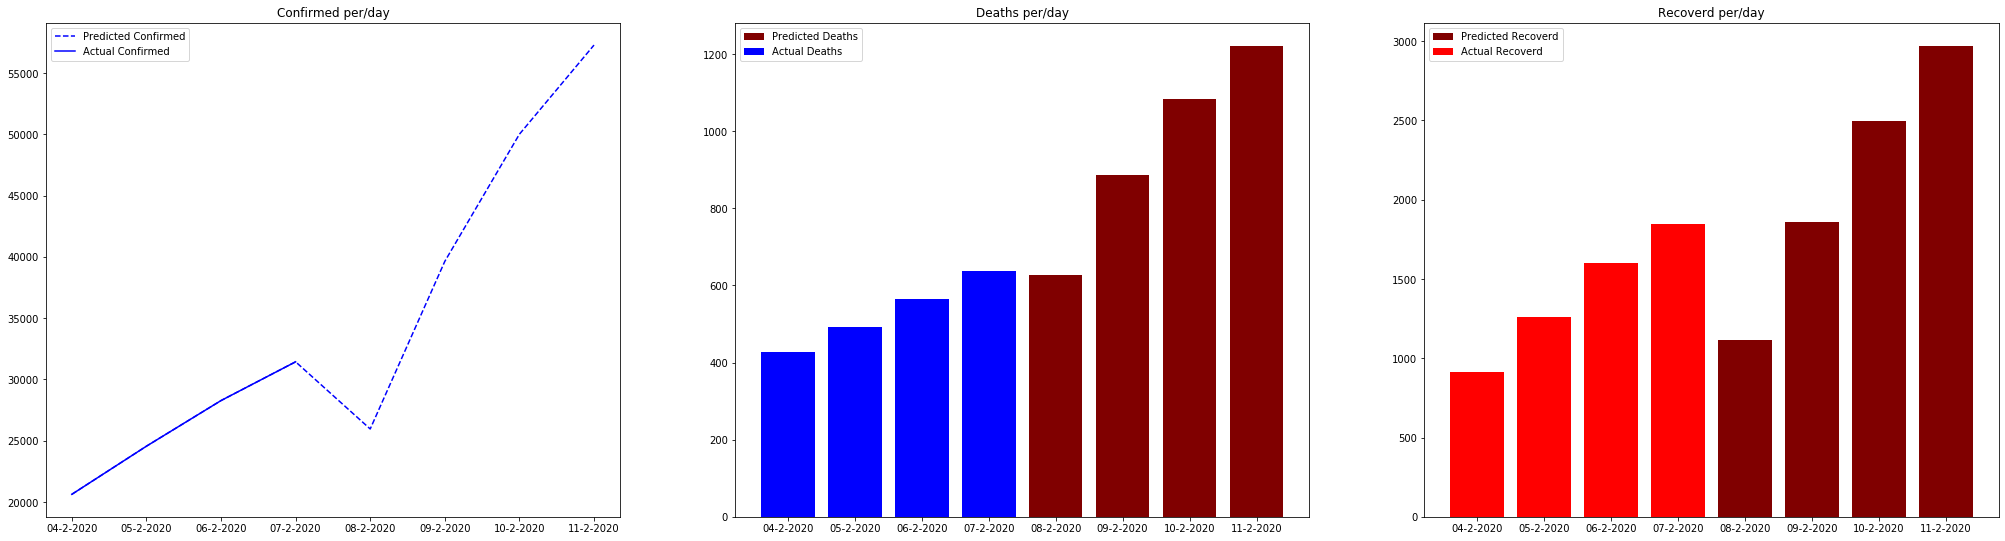

In [30]:
day = ['04-2-2020','05-2-2020','06-2-2020','07-2-2020','08-2-2020','09-2-2020','10-2-2020','11-2-2020']

fig = plt.figure(figsize=(35, 20))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)                                            

ax1.plot(day,next4_0,color='blue',ls='--',clip_on=True,label='Predicted Confirmed')
ax1.plot(BACK4_0,color='blue',clip_on=True,label='Actual Confirmed')

ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,next4_1,color='maroon',ls='--',clip_on=True,label='Predicted Deaths')
ax2.bar(day,BACK4_1,color='blue',clip_on=True,label='Actual Deaths')
ax2.legend()

ax2.title.set_text("Deaths per/day")
ax2.legend()

ax3.bar(day,next4_2,color='maroon',ls='--',clip_on=True,label='Predicted Recoverd')
ax3.bar(day,BACK4_2,color='red',clip_on=True,label='Actual Recoverd')


ax3.title.set_text("Recoverd per/day")
ax3.legend()

plt.show()

In [31]:
dataf = pd.DataFrame(data=[day,next4_0, next4_1,next4_2])
dataf = dataf.T
dataf.columns=['Date','Confirmed','Deaths','Recoverd']

dataf.Confirmed = dataf.Confirmed.apply(lambda x : np.round(x,0))
dataf.Deaths = dataf.Deaths.apply(lambda x : np.round(x,0))
dataf.Recoverd = dataf.Recoverd.apply(lambda x : np.round(x,0))

dataf

,Date,Confirmed,Deaths,Recoverd
0,04-2-2020,20626.0,426.0,913.0
1,05-2-2020,24553.0,492.0,1260.0
2,06-2-2020,28276.0,565.0,1601.0
3,07-2-2020,31439.0,638.0,1844.0
4,08-2-2020,25959.0,626.0,1113.0
5,09-2-2020,39634.0,887.0,1860.0
6,10-2-2020,50008.0,1083.0,2499.0
7,11-2-2020,57281.0,1220.0,2968.0
